# Transforming Vertical Coordinates

A common need in the analysis of ocean and atmospheric data is to transform the vertical coordinate from its original coordinate (e.g. depth) to a new coordinate (e.g. density).
Xgcm supports this sort of one-dimensional coordinate transform on `Axis` and `Grid` objects using the `transform` method.
Two algorithms are implemented:

- _Linear interpolation:_ Linear interpolation is designed to interpolate intensive quantities (e.g. temperature) from one coordinate to another. This method is suitable when the target coordinate is monotonically increasing or decreasing and the data variable is intensive. For example, you want to visualize oxygen on density surfaces from a z-coordinate ocean model.
- _Conservative remapping:_ This algorithm is designed to conserve extensive quantities (e.g. transport, heat content). It requires knowledge of cell bounds in both the source and target coordinate. It also handles non-monotonic target coordinates.

On this page, we explain how to use these coordinate transformation capabilities.

In [1]:
from xgcm import Grid
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## 1D Toy Data Example

First we will create a simple, one-dimensional dataset to illustrate how the `transform` function works.
This dataset contains

- a coordinate called `z`, representing the original depth coordinate

- a data variable called `theta`, a function of `z`, which we want as our new vertical coordinate

- a data variable called `phi`, akso a function of `z`, which represents the data we want to transform into this new coordinate space

In an oceanic context `theta` might be density and `phi` might be oxygen.
In an atmospheric context, `theta` might be potential temperature and `phi` might be potential vorticity.

In [2]:
z = np.arange(2, 12)
theta = xr.DataArray(np.log(z), dims=['z'], coords={'z': z})
phi = xr.DataArray(np.flip(np.log(z)*0.5+ np.random.rand(len(z))), dims=['z'], coords={'z':z})
ds = xr.Dataset({'phi': phi, 'theta': theta})
ds

<xarray.Dataset>
Dimensions:  (z: 10)
Coordinates:
  * z        (z) int64 2 3 4 5 6 7 8 9 10 11
Data variables:
    phi      (z) float64 2.184 1.246 1.974 1.473 ... 1.623 1.159 0.7282 0.554
    theta    (z) float64 0.6931 1.099 1.386 1.609 ... 2.079 2.197 2.303 2.398

Let's plot this data. Note that, for a simple 1D profile, we can easily visualize `phi` in `theta` space by simply plotting `phi` vs. `theta`. This is essentially a form of linear interpolation, performed automatically by matplotlib when it draws lines between the discrete points of our data.

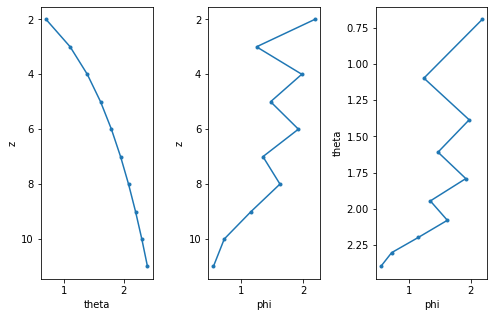

In [3]:
def plot_profile():
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[8,5])
    ds.theta.plot(ax=ax1, y='z', marker='.', yincrease=False)
    ds.phi.plot(ax=ax2, y='z', marker='.', yincrease=False)
    ds.swap_dims({'z': 'theta'}).phi.plot(ax=ax3, y='theta', marker='.', yincrease=False)
    fig.subplots_adjust(wspace=0.5)
    return ax3

plot_profile();

### Linear transformation

Ok now lets transform `phi` to `theta` coordinates using linear interpolation.
A key part of this is to define specific `theta` levels onto which we want to interpolate the data.

In [4]:
# First create an xgcm grid object
grid = Grid(ds, coords={'Z': {'center':'z'}}, periodic=False)

# define the target values in density, linearly spaced
theta_target = np.linspace(0, 3, 20)

# and transform
phi_transformed = grid.transform(ds.phi, 'Z', theta_target, target_data=ds.theta)
phi_transformed

<xarray.DataArray 'phi' (theta: 20)>
array([       nan,        nan,        nan,        nan,        nan,
       1.96125976, 1.59612343, 1.26318133, 1.66235131, 1.8956192 ,
       1.54115365, 1.78482785, 1.53877378, 1.56810697, 1.10425511,
       0.60783917,        nan,        nan,        nan,        nan])
Coordinates:
  * theta    (theta) float64 0.0 0.1579 0.3158 0.4737 ... 2.526 2.684 2.842 3.0

Now let's see what the result looks like.

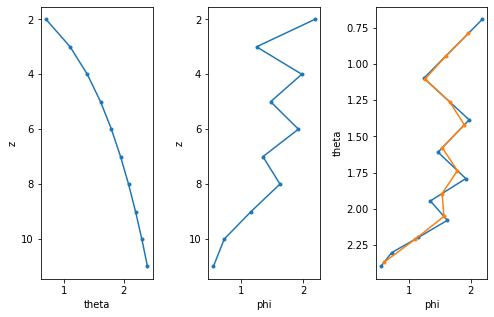

In [5]:
ax = plot_profile()
phi_transformed.plot(ax=ax, y='theta', marker='.')

Not too bad. We can increase the number of interpolation levels to capture more of the small scale structure.

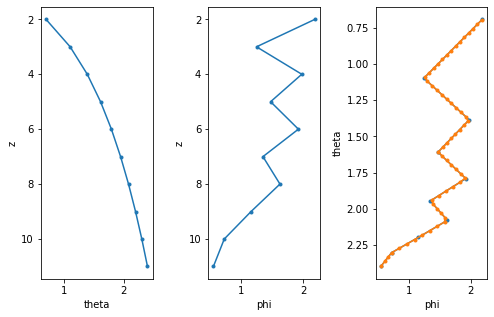

In [6]:
target_theta = np.linspace(0,3, 100)
phi_transformed = grid.transform(ds.phi, 'Z', target_theta, target_data=ds.theta)
ax = plot_profile()
phi_transformed.plot(ax=ax, y='theta', marker='.')

Note that by default, values of `theta_target` which lie outside the range of `theta` have been masked (set to `NaN`).
To disable this behavior, you can pass `mask_edges=False`; values outside the range of `theta` will be filled with the nearest valid value.

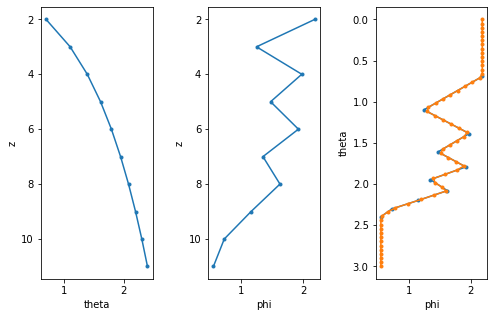

In [7]:
target_theta = np.linspace(0,3, 60)
phi_transformed = grid.transform(ds.phi, 'Z', target_theta, target_data=ds.theta, mask_edges=False)
ax = plot_profile()
phi_transformed.plot(ax=ax, y='theta', marker='.')

### Conservative transformation

Conservative transformation is designed to preseve the total sum of `phi` over the `Z` axis.
It presumes that `phi` is an _extensive quantity_, i.e. a quantity that is already volume weighted, with respect to the Z axis: for example, units of `Kelvins * meters` for heat content, rather than just `Kelvins`.
The conservative method requires more input data at the moment.
You have to not only specify the coordinates of the cell centers, but also the cell faces (or bounds/boundaries). In xgcm we achieve this by defining the bounding coordinates as the `outer` axis position.
The target `theta` values are likewise intepreted as cell boundaries in `theta`-space.
In this way, conservative transformation is similar to calculating a histogram.

In [8]:
# define the cell bounds in depth
zc = np.arange(1,12)+0.5

# add them to the existing dataset
ds = ds.assign_coords({'zc': zc})
ds

<xarray.Dataset>
Dimensions:  (z: 10, zc: 11)
Coordinates:
  * z        (z) int64 2 3 4 5 6 7 8 9 10 11
  * zc       (zc) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
Data variables:
    phi      (z) float64 2.184 1.246 1.974 1.473 ... 1.623 1.159 0.7282 0.554
    theta    (z) float64 0.6931 1.099 1.386 1.609 ... 2.079 2.197 2.303 2.398

In [9]:
# Recreate the grid object with a staggered `center`/`outer` coordinate layout
grid = Grid(ds, coords={'Z':{'center':'z', 'outer':'zc'}},
            periodic=False)
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   z --> outer
  * outer    zc --> center

Currently the `target_data`(`theta` in this case) has to be located on the `outer` coordinate for the conservative method (compared to the `center` for the linear method).

We can easily interpolate `theta` on the outer coordinate with the grid object.

In [10]:
ds['theta_outer'] = grid.interp(ds.theta, 'Z', boundary='fill')
ds['theta_outer']

<xarray.DataArray 'theta_outer' (zc: 11)>
array([0.34657359, 0.89587973, 1.24245332, 1.49786614, 1.70059869,
       1.86883481, 2.01267585, 2.13833306, 2.24990484, 2.35024018,
       1.19894764])
Coordinates:
  * zc       (zc) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5

Now lets transform the data using the conservative method. Note that the target values will now be interpreted as cell bounds and not cell centers as before.

In [11]:
# define the target values in density
theta_target = np.linspace(0,3, 20)

# and transform
phi_transformed_cons = grid.transform(ds.phi,
                                      'Z',
                                      theta_target,
                                      method='conservative',
                                      target_data=ds.theta_outer)
phi_transformed_cons

/Users/juliusbusecke/code/xgcm/xgcm/transform.py:250: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  output_dtypes=[phi.dtype],


<xarray.DataArray 'phi' (theta_outer: 19)>
array([0.        , 0.        , 0.50538638, 0.62778271, 0.62778271,
       0.60823241, 0.56782993, 0.68425695, 1.29607224, 1.25852971,
       1.37317433, 1.82488407, 1.69864816, 1.93256946, 1.20432969,
       0.        , 0.        , 0.        , 0.        ])
Coordinates:
  * theta_outer  (theta_outer) float64 0.07895 0.2368 0.3947 ... 2.763 2.921

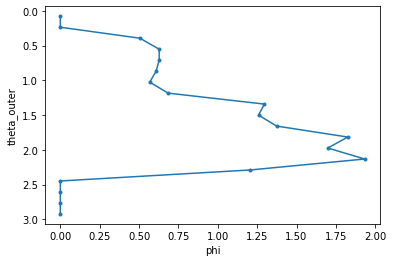

In [12]:
phi_transformed_cons.plot(y='theta_outer', marker='.', yincrease=False)

There is no point in comparing `phi_transformed_cons` directly to `phi` or the results of linear interoplation, since here we have reinterpreted `phi` as an extensive quantity.
However, we can verify that the sum of the two quantities over the Z axis is exactly the same.

In [13]:
ds.phi.sum().values

array(14.20947876)

In [14]:
phi_transformed_cons.sum().values

array(14.20947876)

## Realistic Data Example

To illustrate these features in a more realistic example, we use data from the [NCEP Global Ocean Data Assimilation](https://www.cpc.ncep.noaa.gov/products/GODAS/) (GODAS).
This data are available from the [Pangeo Cloud Data Library](https://catalog.pangeo.io/browse/master/ocean/GODAS/).
We can see that this is a full, global, 4D ocean dataset.

In [17]:
from intake import open_catalog

# cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
# ds  = cat["GODAS"].to_dask()
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["GODAS"].to_dask()
ds

ValueError: Bad Request: https://www.googleapis.com/download/storage/v1/b/pangeo-ncep-godas/o/.zmetadata?alt=media
b'User project specified in the request is invalid.'

The grid is missing an `outer` coordinate for the Z axis, so we will construct one.
This will be needed for conservative interpolation.

In [18]:
level_outer_data = np.pad(ds.level_w.values, [1, 0])
level_outer = xr.DataArray(
    level_outer_data,
    dims=['level_outer'],
    coords={'level_outer': ('level_outer', level_outer_data)}
)
ds = ds.assign_coords({'level_outer': level_outer})

AttributeError: 'Dataset' object has no attribute 'level_w'

Now we create a `Grid` object for this dataset.

In [ ]:
grid = Grid(ds, coords={'Z': {'center': 'level', 'outer': 'level_outer'},
                        'X': {'center': 'lon', 'right': 'lon_u'},
                        'Y': {'center': 'lat', 'right': 'lat_u'}},
            periodic=['X'])
grid

### Linear Interpolation

To illustrate linear interpolation, we will interpolate salinity onto temperature surface.

In [19]:
# convert to standard units
theta = ds.pottmp - 273.15 
salt = 1000 * ds.salt

AttributeError: 'Dataset' object has no attribute 'pottmp'

In [20]:
target_theta_levels = np.arange(-2, 36)
salt_on_theta = grid.transform(salt, 'Z', target_theta_levels, target_data=theta, method='linear')
salt_on_theta

NameError: name 'salt' is not defined

Note that the computation is lazy. (No data has been downloaded or computed yet.)
We can trigger computation by plotting something.

In [21]:
salt_on_theta.isel(time=0).sel(pottmp=18).plot()

NameError: name 'salt_on_theta' is not defined

In [22]:
salt_on_theta.isel(time=0).mean(dim='lon').plot(x='lat')

NameError: name 'salt_on_theta' is not defined

## Conservative Interpolation

To do conservative interpolation, we will attempt to calculate the meridional overturning in temperature space.
Note that this is not a perfectly precise calculation, since the GODAS data are not exactly volume conserving as provided.
However, it's sufficient to illustrate the basic principles of the calculation.

To use conservative interpolation, we have to go from an intensive quantity (velocity) to an extensive one (velocity times cell thickness).
We fill any missing values with 0, since they don't contribute to the transport.

In [23]:
thickness = grid.diff(ds.level_outer, 'Z')
v_transport =  ds.vcur * thickness
v_transport = v_transport.fillna(0.).rename('v_transport')
v_transport

AttributeError: 'Dataset' object has no attribute 'level_outer'

We also need to interpolate `theta`, our target data for interoplation, to the same horizontal position as `v_transport`. This means moving from cell center to cell corner.
This step introduces some considerable errors, particularly near the boundaries of bathymetry.
(Xgcm currently has no special treatment for internal boundary conditions--see issue [222](https://github.com/xgcm/xgcm/issues/240).)

In [24]:
theta = grid.interp(theta,['X', 'Y'], boundary='extend').rename('theta')
theta

KeyError: 'X'

In [25]:
v_transport_theta = grid.transform(v_transport, 'Z', target_theta_levels,
                                   target_data=theta, method='conservative')
v_transport_theta

NameError: name 'v_transport' is not defined

Notice that this produced a warning. The `conservative` transformation method natively needs `target_data` to be provided on the cell bounds (here `level_outer`).
Since transforming onto tracer coordinates is a very common scenario, xgcm uses linear interpolation to infer the values on the `outer` axis position.

To demonstrate how to provide provide `target_data` on the outer grid position, we reproduce the steps xgcm executes internally:

In [26]:
theta_outer = grid.interp(theta,['Z'], boundary='extend')
# the data cannot be chunked along the transformation axis
theta_outer = theta_outer.chunk({'level_outer': -1}).rename('theta')
theta_outer

ValueError: some chunks keys are not dimensions on this object: {'level_outer'}

When we apply the transformation we can see that the results in this case are equivalent:

In [27]:
v_transport_theta_manual = grid.transform(v_transport, 'Z', target_theta_levels,
                                   target_data=theta_outer, method='conservative')

# Warning: this step takes a long time to compute. We will only compare the first time value
xr.testing.assert_allclose(v_transport_theta_manual.isel(time=0), v_transport_theta.isel(time=0))

NameError: name 'v_transport' is not defined

Now  we verify visually that the vertically integrated transport is conserved under this transformation.

In [28]:
v_transport.isel(time=0).sum(dim='level').plot(robust=True)

NameError: name 'v_transport' is not defined

In [29]:
v_transport_theta.isel(time=0).sum(dim='theta').plot(robust=True)

NameError: name 'v_transport_theta' is not defined

Finally, we attempt to plot a crude meridional overturning streamfunction for a single timestep.

In [30]:
dx = 110e3 * np.cos(np.deg2rad(ds.lat_u))
(v_transport_theta.isel(time=0) * dx).sum(dim='lon_u').cumsum(dim='theta').plot.contourf(x='lat_u', levels=31)

AttributeError: 'Dataset' object has no attribute 'lat_u'

## Performance
By default xgcm performs some simple checks when using `method='linear'`. It checks if the last value of the data is larger than the first, and if not, the data is flipped.This ensures that monotonically decreasing variables, like temperature are interpolated correctly. These checks have a performance penalty (~30% in some preliminary tests).If you have manually flipped your data and ensured that its monotonically increasing, you can switch the checks off to get even better performance.
```
grid.transform(..., method='linear', bypass_checks=True)```